In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from tqdm import tqdm
from scipy import ndimage

In [49]:
import torch.nn.functional as F
import torch as tc
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from helpers_img import *
from NeuralNets import *
#from training_NN import *
from preprocessing import *
from Post_processing import *

# try to improve simple_net predictions

# Define A NewNet

In [3]:
class DeepNet(tc.nn.Module):
    def __init__(self,dropout,features=3):
        super(DeepNet,self).__init__()
        self.conv1=tc.nn.Conv2d(features,32,kernel_size=(3,3))
        self.pool1= tc.nn.MaxPool2d(kernel_size = (2,2))
        self.drop1=tc.nn.Dropout(dropout)
        self.batch1=tc.nn.BatchNorm2d(32)
        self.conv2=tc.nn.Conv2d(32,64,kernel_size=(4,4))
        self.pool2 = tc.nn.MaxPool2d(kernel_size = (2,2))
        self.drop2=tc.nn.Dropout(dropout)
        self.batch2=tc.nn.BatchNorm2d(64)
        self.conv3=tc.nn.Conv2d(64,128,kernel_size=(3,3))
        self.pool3= tc.nn.MaxPool2d(kernel_size = (2,2))
        self.drop3=tc.nn.Dropout(dropout)
        self.batch3=tc.nn.BatchNorm2d(128)
        self.conv4=tc.nn.Conv2d(128,256,kernel_size=(3,3))
        self.pool4 = tc.nn.MaxPool2d(kernel_size = (2,2))
        self.drop4=tc.nn.Dropout(dropout)
        self.batch4=tc.nn.BatchNorm2d(256)
        self.fc1=tc.nn.Linear(256,256)
        self.drop5 = tc.nn.Dropout(dropout)
        self.fc2=tc.nn.Linear(256,1)

    def forward(self,x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = self.batch1(self.drop1(x))
        x = F.relu(self.pool2(self.conv2(x)))
        x = self.batch2(self.drop2(x))
        
        x = F.relu(self.pool3(self.conv3(x)))
        x = self.batch3(self.drop3(x))
        
        x = F.relu(self.pool4(self.conv4(x)))
        x = self.batch4(self.drop4(x))
        
        x = x.view(-1,256)
        x = F.relu(self.fc1(x))
        x = self.drop5(x)
        x= tc.sigmoid(self.fc2(x))
        #x = self.fc2(x)
        return x
    

In [4]:
? tc.nn.BatchNorm2d

In [5]:
def img_crop_mod(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(h,imgheight-h,h):
        for j in range(w,imgwidth-w,w):
            if is_2d:
                im_patch = im[j-w:j+2*w, i-h:i+2*h]
            else:
                im_patch = im[j-w:j+2*w, i-h:i+2*h, :]
            list_patches.append(im_patch)
    return list_patches

In [17]:
class DatasetDeepNet(Dataset):
    def __init__(self,root_dir, do_flip=False, do_rotation=False,do_train=False):
        self.image_dir = root_dir + "images/"
        self.files = os.listdir(self.image_dir)
        self.gt_dir = root_dir + "groundtruth/"
        self.rot_len=0
        self.flip_len=0
        self.train = do_train
        self.initial_len=len(self.files)
        # rotation
        if do_rotation:
            self.rot_len= len(self.files)
            self.files = [*self.files*4]
        #flip 
        if do_flip:
            self.flip_len=len(self.files)
            self.files= [*self.files*2]
        
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,index):
        image = [load_image(self.image_dir + self.files[index])]
        gt_image = [load_image(self.gt_dir + self.files[index])]
        if self.rot_len>0:
            image,gt_image = rotation(image,gt_image)
        if self.flip_len>0:
            image,gt_image = flip(image,gt_image)
        
        i = index//self.initial_len
        image,gt_image = image[i],gt_image[i]
        image = add_border(image,432)
        train_sub_images = [img_crop_mod(image, 16, 16)]
        train_mask_label = [img_crop(gt_image,16,16)]
        train_mask_label = from_mask_to_vector(train_mask_label,0.25)
        train_sub_images = transform_subIMG_to_Tensor(train_sub_images)
        mean = train_sub_images.mean()
        std = train_sub_images.std()
        train_sub_images = (train_sub_images-mean)/std
        if self.train:
            train_sub_images, train_mask_label = reduce_dataset(train_sub_images,train_mask_label)
            for l in range(10):
                new_indices= np.random.permutation(len(train_mask_label))
                train_sub_images=train_sub_images[new_indices]
                train_mask_label=train_mask_label[new_indices]
            
        return train_sub_images, 1*train_mask_label

In [7]:
class TestsetDeepNet(Dataset):
    def __init__(self,root_dir, nb_test):
        self.root_dir = root_dir
        self.nb_test = nb_test
    def __len__(self):
        return self.nb_test
    
    def __getitem__(self,index):
        dir_test = self.root_dir + 'test_'+str(index+1)+'/'
        files_test = os.listdir(dir_test)
        img_test = load_image(dir_test + files_test[0])
        original_img = img_test
        img_test = add_border(img_test,608+32)
        img_test=[img_crop_mod(img_test, 16, 16)]
        img_test=transform_subIMG_to_Tensor(img_test)
        img_test = (img_test-img_test.mean())/img_test.std()
        return img_test,original_img
        
        
        

In [8]:
def train_model_Adam_v2( model, dataset, max_epochs, lr, mini_batch_size, w=48, h=48, features=3, threshold=0.01):
    '''train the Neural Net using Adam as optimizer and an binary cross entropy loss'''
    #optimizer=tc.optim.SGD(model.parameters(),lr)
    train_loader = DataLoader(dataset,batch_size=mini_batch_size)
    optimizer=tc.optim.Adam(model.parameters(),lr)
    criterion= tc.nn.BCELoss()
    losses=[]
    training_errors = []
    if tc.cuda.is_available():
        model.cuda()
        criterion.cuda()
    
    for epoch in tqdm(range(max_epochs)):
        model.is_training=True
        model.train()
    
        for train_data,label in train_loader:
            train_data = train_data.view(-1,features,w,h)
            label = label.view(-1,1).type(tc.FloatTensor)
            if tc.cuda.is_available():
                train_data = train_data.cuda()
                label = label.cuda()
            output= model(train_data).view(-1,1)
            #print(output,tc.LongTensor(np.array([1*label[i:i+mini_batch_size]]).reshape(-1,1)))
            loss= criterion(output,label)
            model.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss)
        # compute training error
        '''
        model.eval()
        test = model(train_data)
        test = test.cpu()
        prediction= test[:]>0.5
        
        prediction= 1*(prediction.numpy()[:] != label.reshape(-1,1)[:])
        
        training_error = np.sum(prediction)/len(prediction)
        training_errors.append(training_error*100)
        if training_error< threshold:
            break
        
    plt.figure()
    plt.plot(np.arange(epoch+1)+1,training_errors)
    plt.xlabel('epoch')
    plt.ylabel('training_errors')
    plt.show()
    '''
    plt.figure()
    plt.plot(np.arange(epoch+1)+1,losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
    model.cpu()    
    return model

In [9]:
def trainDeepNet(root_dir, max_epochs, lr, mini_batch_size, dropout=0, model = None):
    if model == None:
        model = DeepNet(dropout)
    
    dataset = DatasetDeepNet(root_dir, do_flip=True, do_rotation=True,do_train=False)
    
    model = train_model_Adam_v2( model, dataset, max_epochs, lr, mini_batch_size)
    return model

In [ ]:
root_dir = 'training/'
max_epochs = 10
lr = 1e-5
mini_batch_size = 2
dropout = 0.5
#np.random.seed(32)
model = trainDeepNet(root_dir, max_epochs, lr, mini_batch_size,dropout=dropout, model = model)

 40%|████      | 4/10 [21:04<31:26, 314.38s/it]

In [34]:
def plot_image(root_dir, nb_image, model):
    dataset = TestsetDeepNet(root_dir,50)
    image, original = dataset.__getitem__(nb_image)
    if tc.cuda.is_available():
        model.cuda()
        image=image.cuda()
    model.eval()
    prediction = model(image).detach().cpu().numpy().reshape(-1,)
    prediction = 1*(prediction>0.5)
    model.cpu()
    print(prediction.shape)
    prediction = label_to_img(608, 608, 16, 16, prediction)
    #prediction=post_processing(prediction,32,9,3,3)
    
    original  = make_img_overlay(original, prediction)
    
    plt.figure(figsize=(10,10))
    plt.imshow(original)

    

(1444,)


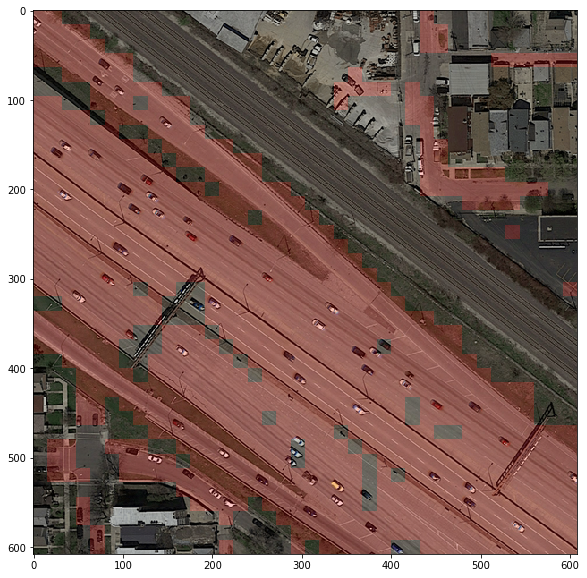

In [56]:
 plot_image('test_set_images/', 8, model)

In [53]:
def create_submission(root_dir, model, name_file, do_postprocess=False):
    ''' the function takes as input the test data and the models used for prediction. 
    If a list of model is given, the prediction will be done with majority vote. 
    
    The function is written explicitly for prediction using SimpleNet model.
    
    test_data: list of images.
    
    models: list of models or single model
    
    w, h: width and high of the patches'''
    
    # from list to Tensor
    dataset = TestsetDeepNet(root_dir,50)
    test_loader = DataLoader(dataset)
    predictions = []
    if tc.cuda.is_available():
        model.cuda()
    for test_data,_ in tqdm(test_loader):
        test_data = test_data.view(-1,3,48,48)
        if tc.cuda.is_available():
            test_data=test_data.cuda()
        prediction = model(test_data).detach().cpu().numpy()
        
        prediction = 1*(prediction > 0.5)
     
        predictions.append(prediction.reshape(-1,))
    if do_postprocess:
        for i in range(len(predictions)):
            predictions[i]=complete_lines(predictions[i],35)
            predictions[i] = remove_isolated_connected_component(predictions[i],3)

    # from patch to image
    list_of_masks=[label_to_img(608, 608, 16, 16, predictions[k]) for k in range(50)]
    list_of_string_names = []
    for i in range(50):
        plt.imsave( "prediction_"+str(i+1)+".png", list_of_masks[i], cmap = matplotlib.cm.gray)
        list_of_string_names.append("prediction_" + str(i+1) + ".png")
    # create file submission
    masks_to_submission(name_file, *list_of_string_names)

In [57]:
create_submission('test_set_images/', model, 'submissionDN.csv', do_postprocess=False)

100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


In [59]:
model.cpu()
tc.save(model,'model_DeepNet5.pt')

/home/stefano/anaconda3/envs/diego/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DeepNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [42]:
model = tc.load('model_DeepNet4.pt')